In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
#!unzip /content/archive.zip
import warnings
warnings.filterwarnings("ignore")

Dataset : https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers

In [11]:
df = pd.read_csv("./Churn_Modelling.csv")
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.drop(columns=["RowNumber","CustomerId","Surname"],inplace=True)

In [5]:
maps = {
    "Balance":"int64",
    "EstimatedSalary":"int64"
}
df = df.astype(maps)

In [6]:
df = pd.get_dummies(data=df,columns=["Geography","Gender"],drop_first=True)

In [7]:
from sklearn.model_selection import train_test_split
X=df.drop(columns=["Exited"])
y=df["Exited"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [20]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
#from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import L2

import tensorboard

# Load the TensorBoard notebook extension.
%load_ext tensorboard

tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.11.0'

In [15]:
num_units = X_train.shape[1]
num_classes = y_train.nunique()
print(num_units,num_classes)

11 2


In [41]:
model = Sequential()
#initializer = tf.keras.initializers.HeNormal()
model.add(Dense(units=128,input_dim=num_units,activation='relu'))
model.add(BatchNormalization(momentum=0.9,epsilon=0.001,center=True,scale=True))
model.add(Dense(units=64,activation='relu'))
model.add(BatchNormalization(momentum=0.99,epsilon=0.001,center=True,scale=True))
#model.add(Dense(units=8,activation='relu',kernel_initializer=initializer))
# model.add(Dense(units=32,activation='relu',kernel_constraint=MaxNorm(3)))
model.add(Dense(units=16,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32,activation='relu',kernel_regularizer=L2(0.3)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=num_classes-1,activation='sigmoid'))


In [42]:
w_old = model.get_weights()[0]

In [43]:
loss = BinaryCrossentropy(from_logits=True)
adam = Adam(learning_rate=0.01, clipvalue=1.0)
model.compile(optimizer=adam,loss=loss,metrics=['accuracy'])

In [34]:
!rm -rf ./logs/
callbacks = [EarlyStopping(patience=2),
#             ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
             TensorBoard(log_dir='./logs')]

In [44]:
history = model.fit(x=X_train_scaled,y=y_train,epochs=100,
                    validation_split=0.2,callbacks=[callbacks])
# if we don't use early stopping model will run for 100 epochs &  overfit


Epoch 1/100
200/200 [==============================] - 4s 6ms/step - loss: 0.8212 - accuracy: 0.7973 - val_loss: 0.4095 - val_accuracy: 0.8263
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4220 - accuracy: 0.8252 - val_loss: 0.3983 - val_accuracy: 0.8400
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8300 - val_loss: 0.3806 - val_accuracy: 0.8469
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4022 - accuracy: 0.8358 - val_loss: 0.3884 - val_accuracy: 0.8525
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4002 - accuracy: 0.8417 - val_loss: 0.3751 - val_accuracy: 0.8569
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4013 - accuracy: 0.8458 - val_loss: 0.4326 - val_accuracy: 0.8512
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.3945 - accuracy: 0.8523 - val_loss: 0.3992 - val_accuracy: 0.8500

In [45]:
## check gradient change

w_new = model.get_weights()[0]
nu = 0.01
pct_change = 100*(w_new - w_old)/nu

pct_change[0]

array([ 1218.4021  ,  4134.1655  ,  3844.7136  ,   114.03866 ,
       -1413.1979  ,  1129.1449  , -4681.9136  ,   793.7409  ,
       -1714.5652  , -2312.4014  , -3238.376   ,  -943.7657  ,
        -238.5715  ,  3098.3003  ,  -164.17627 ,   780.9128  ,
       -2351.8503  ,  1579.0118  ,  2321.1477  ,  2020.0106  ,
         157.65025 ,   473.45697 ,  -256.40295 ,  1229.4015  ,
        2892.0525  , -4054.1917  ,   357.30435 ,  -739.07513 ,
       -1435.4879  ,   398.92688 ,  2179.1052  ,  1394.8523  ,
        -803.50323 , -3032.9387  , -1850.7534  ,   985.8366  ,
        2853.0205  ,  5215.3613  ,   692.2223  ,   429.47397 ,
        2257.27    , -1456.1028  ,  1201.7805  , -1095.8391  ,
        2340.632   , -1779.7675  , -3767.9822  ,  2181.2424  ,
       -3495.102   , -1211.7657  ,  2059.5857  ,   641.0216  ,
       -3079.3342  ,   -44.258907,  -766.2634  ,   257.63617 ,
        -106.6957  ,  -738.38293 ,  1043.0656  ,  3984.4453  ,
        -260.61758 ,   493.46506 ,  3240.5884  ,  -443.

In [28]:
%tensorboard --logdir logs


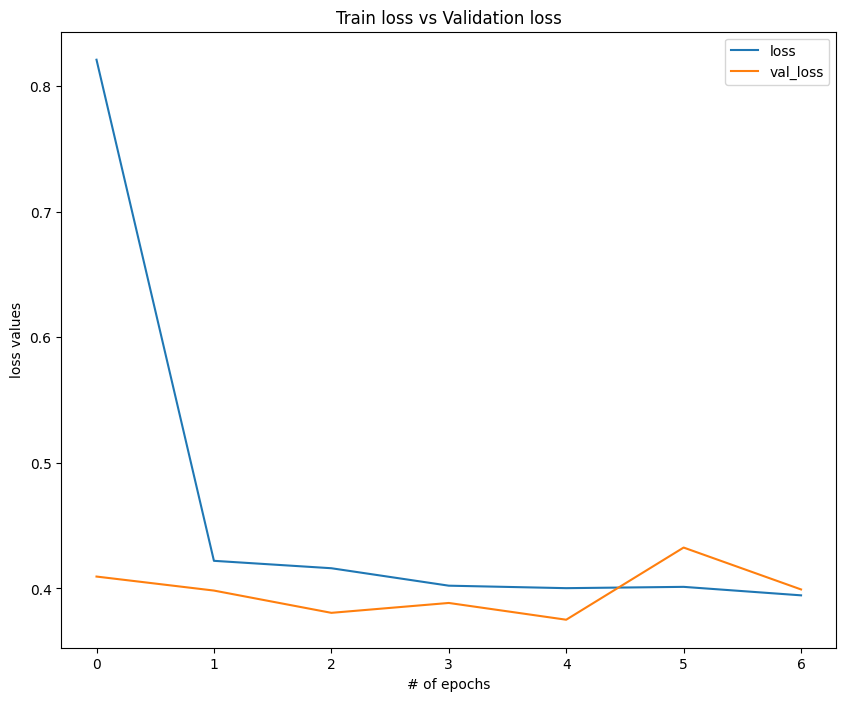

In [46]:
plt.figure(figsize=(10,8))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.xlabel("# of epochs")
plt.ylabel("loss values")
plt.title("Train loss vs Validation loss")
plt.legend()
plt.show()

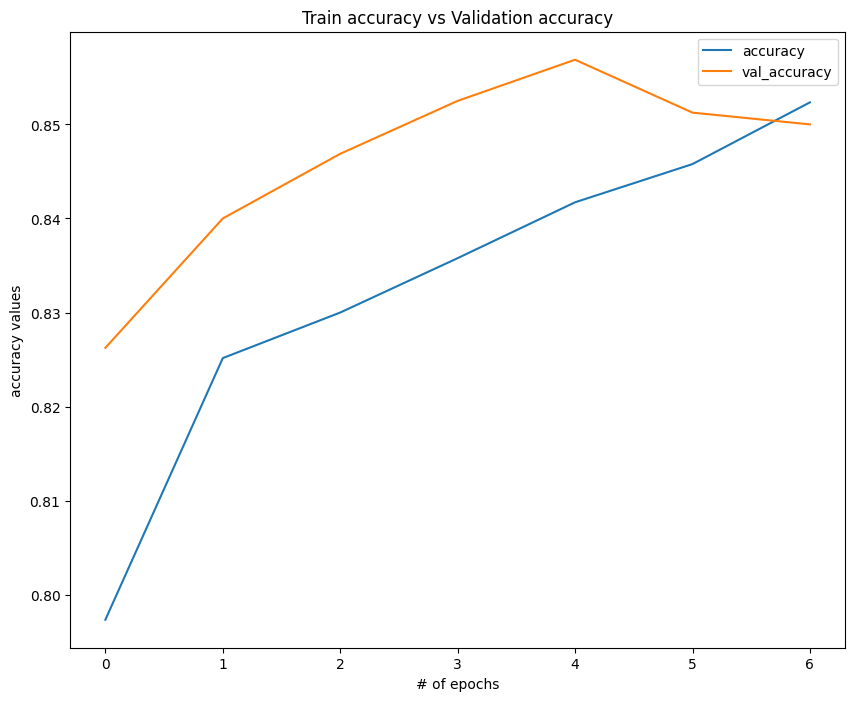

In [47]:
plt.figure(figsize=(10,8))
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.xlabel("# of epochs")
plt.ylabel('accuracy values')
plt.title("Train accuracy vs Validation accuracy")
plt.legend()
plt.show()

In [48]:
pred = model.predict(X_test_scaled)
y_pred = np.where(pred>0.5,1,0)

63/63 [==============================] - 0s 2ms/step


In [49]:
from sklearn.metrics import confusion_matrix,accuracy_score

score = accuracy_score(y_test,y_pred)
print(score)
cm = confusion_matrix(y_test,y_pred)
print(cm)

0.852
[[1536   71]
 [ 225  168]]


In [50]:
# 0.8545
# [[1546   61]
#  [ 230  163]]

# 0.8545
# [[1550   57]
#  [ 234  159]]

#0.859
# [[1540   67]
#  [ 215  178]]